<p style="text-align:right;">Daniel Böckenhoff, Max-Planck-Institute for Plasmaphysics</p>

## Convolutional Neural Networks to recognise numbers with the MNIST database
After we have experienced with fully connected NNs that it is hard to get accuracies above ~96% we investigate the power of convolutional neural networks. Finally we will investigate the robustnes of our dataset.

**What you will learn:**
 - Further classification error analysis
 - inspect failure cases and understand how to approach to make a NN more robust
 
**Task:**
Carefully read the cells and execute them (Shift enter or menu panel). Complete the exercises marked as such.
  
**Note:**
You can skip until model definition ("Define and train a convolutional neural network") if you have done the mnist_dense exercise.

## Image Data Preparation
We will load the mnist data set with the *keras.datasets* backend.

In [1]:
import tensorflow as tf
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
import shap

In [2]:
# Set the path to the directory where we have already downloaded the data
local_path = !pwd # under linux/mac
data_path = local_path[0] + '/../data/mnist.npz'  # if no path were given, keras would download the dataset

# Load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(data_path)
class_names = list(set(y_train))
num_classes = len(class_names)  # 10
num_imgs = len(y_train) + len(y_test)

print("Number of samples in whole data set: {num_imgs}".format(**locals()))

Number of samples in whole data set: 70000


## Make TensorFlow Datasets


**Note:** Training, Validation and Test Split
A rule of thum is to split the data set in taining, validation and test set by the ratio 80:10:10.
A specialty in the mnist dataset is the predefined test set which serves the purpose of exact comparability between different research groups.

In [3]:
img_size = x_train.shape[1]  # width and height of all images

# Scale images
x_train = x_train / 255.
x_test = x_test / 255.

# Convert target classes to categorical ones
y_train_labels = y_train
y_test_labels = y_test
y_train = tf.keras.utils.to_categorical(y_train_labels, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

## Define and Train a Convolutional Neural Network
**Layer types:**
 - Conv2D convolutional layer, here inputs are 3dim and the convolution sums over the 3rd dim.
 - MaxPooling2D takes local maxima over a rectangular region.
 - Dropout randomly deactivates neurons during training, which can make training more robust.
 - [BatchNormalization](https://arxiv.org/pdf/1502.03167.pdf), centralizes and scales its input to have approximately 0 mean and variance 1.



**Exercise:**
Implement the a NN architecture similar to that in [this paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). You do not need to read the full paper. Look at figure 2 and use that as inspiration.

**Links:**
* [tf.keras.layers.Reshape](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Reshape)
* [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
* [tf.keras.layers.MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D)
* [tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)


In [4]:
np.random.seed(1)  # so we all get the same pseudorandom results

model = tf.keras.models.Sequential()  # sequential stack of layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.BatchNormalization())

############################################################
# Your modifications to the model here
############################################################

model.add( tf.keras.layers.Dense (num_classes, activation = "softmax"))

# pretty print a summary of the layer types and dimensions
model.summary()

modelfname = "mnist_cnn.h5"

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28)            112       
_________________________________________________________________
dense (Dense)                (None, 28, 10)            290       
Total params: 402
Trainable params: 346
Non-trainable params: 56
_________________________________________________________________


In [5]:
np.random.seed(1)  # so we all get the same pseudorandom results

model = tf.keras.models.Sequential()  # sequential stack of layers

model.add( tf.keras.layers.Input((img_size, img_size)))
model.add( tf.keras.layers.BatchNormalization())
model.add( tf.keras.layers.Reshape((img_size, img_size, 1)))
model.add( tf.keras.layers.Conv2D(6, kernel_size=(3, 3)))
model.add( tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add( tf.keras.layers.Conv2D(16, kernel_size=(3, 3)))
model.add( tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add( tf.keras.layers.Conv2D(120, kernel_size=(5, 5)))
model.add( tf.keras.layers.Reshape((120,)))
model.add( tf.keras.layers.Dense(80, activation=tf.nn.relu))
model.add( tf.keras.layers.Dropout(0.3))
model.add( tf.keras.layers.Dense (num_classes, activation = "softmax"))

# pretty print a summary of the layer types and dimensions
model.summary()

modelfname = "mnist_cnn.h5"

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 28, 28)            112       
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 120)        

In [6]:
# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# Callbacks: What should be done during (long) training?

# Function to store model to file, if validation loss has a new record
# Check always after having seen at least another save_freq examples.
# Default save_freq is once every epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    modelfname, monitor = 'val_loss', mode = 'min', 
    save_best_only = True, verbose = 1)

# Function to decrease learning rate by 'factor'
# when there has been no significant improvement in the last 'patience' epochs.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', mode = 'min', factor = 0.75, patience = 4, verbose = 1)
                         
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=250,
                    verbose=1,
                    validation_split=0.1,
                    callbacks = [checkpoint, reduce_lr]
                   )

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
53750/54000 [============================>.] - ETA: 0s - loss: 0.4089 - accuracy: 0.8737
Epoch 00001: val_loss improved from inf to 0.12681, saving model to mnist_cnn.h5
54000/54000 [==============================] - 13s 233us/sample - loss: 0.4079 - accuracy: 0.8741 - val_loss: 0.1268 - val_accuracy: 0.9703
Epoch 2/20
53750/54000 [============================>.] - ETA: 0s - loss: 0.1289 - accuracy: 0.9609
Epoch 00002: val_loss improved from 0.12681 to 0.06623, saving model to mnist_cnn.h5
54000/54000 [==============================] - 12s 214us/sample - loss: 0.1287 - accuracy: 0.9610 - val_loss: 0.0662 - val_accuracy: 0.9815
Epoch 3/20
53500/54000 [============================>.] - ETA: 0s - loss: 0.0940 - accuracy: 0.9712
Epoch 00003: val_loss improved from 0.06623 to 0.06268, saving model to mnist_cnn.h5
54000/54000 [==============================] - 10s 193us/sample - loss: 0.0940 - accuracy: 0.9712 - val_loss: 0.0627 - v

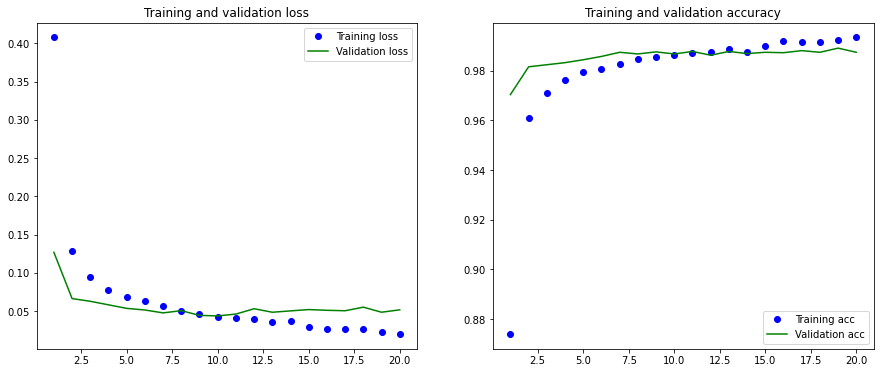

In [8]:
# plot the training history as loss and accuracy curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

_, ax = plt.subplots(ncols = 2, figsize = (15, 6))
ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
ax[0].plot(epochs, val_loss, 'g', label = 'Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'bo', label = 'Training acc')
ax[1].plot(epochs, val_acc, 'g', label = 'Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].legend();

## Evaluation after Training

In [9]:
# Load the parameters with the best validation accuracy during training.
# This works also if you interruped the training!
model.load_weights(modelfname)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 0)
print("Loss on test set:", test_loss, "\nAccuracy on test set:", test_acc)

Loss on test set: 0.038075295180767715 
Accuracy on test set: 0.9866


In [10]:
# make a prediction
prediction = model.predict(x_test)
prediction_class = prediction.argmax(axis = 1)
prediction_confidence = prediction.max(axis = 1)

print("Predicted probabilities for first 5 examples:\n", np.round(prediction[0:5], 3))
print("Predicted classes for first 5 examples:\n", prediction_class[0:5])
print("Probability of prediction:\n", prediction_confidence[0:5])

Predicted probabilities for first 5 examples:
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Predicted classes for first 5 examples:
 [7 2 1 0 4]
Probability of prediction:
 [0.9999927  0.9999995  0.9999926  0.99999714 0.99980813]


In [11]:
sklearn.metrics.confusion_matrix(y_test_labels, prediction_class)

array([[ 975,    0,    1,    0,    0,    0,    1,    1,    2,    0],
       [   0, 1134,    1,    0,    0,    0,    0,    0,    0,    0],
       [   0,    2, 1020,    2,    1,    0,    0,    5,    2,    0],
       [   0,    1,    6,  994,    0,    6,    0,    0,    3,    0],
       [   0,    0,    0,    1,  968,    0,    2,    1,    3,    7],
       [   2,    0,    0,    3,    0,  882,    2,    1,    1,    1],
       [  10,    5,    2,    0,    2,    3,  935,    0,    1,    0],
       [   1,    1,    7,    2,    0,    0,    0, 1013,    1,    3],
       [   1,    0,    4,    0,    0,    0,    1,    2,  965,    1],
       [   3,    3,    1,    6,    2,    4,    0,    3,    7,  980]])

In [12]:
print(sklearn.metrics.classification_report(y_test_labels, prediction_class))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.98       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### Display misclassified numbers

In [13]:
indices = np.arange(len(y_test))[y_test_labels != prediction_class]

Expected 3 , got 5 with prob 0.49203163


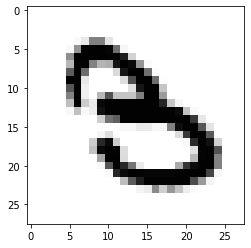

Expected 9 , got 8 with prob 0.9397154


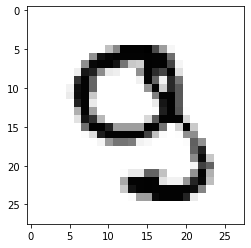

Expected 6 , got 5 with prob 0.5777738


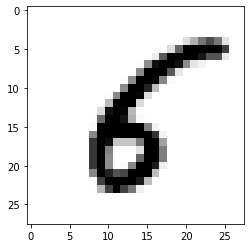

Expected 6 , got 0 with prob 0.8543728


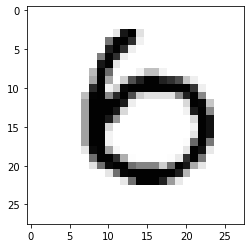

Expected 2 , got 7 with prob 0.6249014


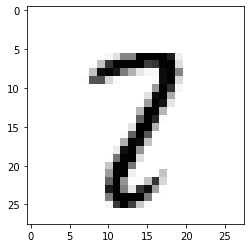

In [14]:
for i in indices[:5]:
    print("Expected", y_test_labels[i], ", got", prediction_class[i], "with prob", prediction_confidence[i])
    # Visualize one sample
    plt.imshow(x_test[i], cmap='Greys')
    plt.show()

## 'Deploy'
We now go 'online' with our newly built model and deploy it to make use of it.

**Usage:**

Run the next cell. A opencv window will pop up. Draw in the canvas with the left mouse button activated. The following commands are available:

**Commands:**
* r to reset the image
* c (calculate) to let the neural network predict the target of your image

<IPython.core.display.Javascript object>


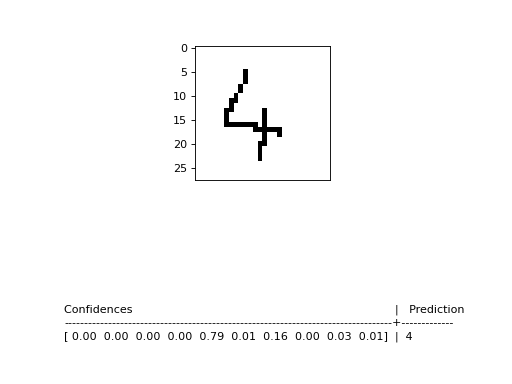

10

In [15]:
# No need to understand the code below !!!
%matplotlib notebook
np.set_printoptions(formatter={'float': '{: .2f}'.format})

img = np.zeros((img_size, img_size), np.uint8)



fig = plt.figure()
ax = fig.add_subplot(211)
artist = ax.imshow(img, cmap='Greys')
ax_text = fig.add_subplot(212)
ax_text.axis('off')
header=ax_text.text(0,0.2,
                    "Confidences" + " " * 75 + "|" "   Prediction",
                    va="bottom", ha="left")  # Table head
separator=ax_text.text(0,0.1,
                    "-" * (82) + "+" + "-" * 13,
                    va="bottom", ha="left")  # Table separator

text=ax_text.text(0,0, "", va="bottom", ha="left")

ax.tick_params(
    axis='both',       # changes apply to both axes
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

drawing = False


def update():
    artist = ax.imshow(img, cmap='Greys')
    artist.set_array(img)
    fig.canvas.draw()
    fig.canvas.flush_events()


def draw(event):
    ix, iy = int(round(event.xdata)), int(round(event.ydata))
    if img[iy, ix] == 0:
        img[iy, ix] = 255
        update()

def pen_down(event):
    global drawing
    drawing = True
    draw(event)
    
def pen_up(event):
    global drawing
    drawing = False

def pen_move(event):
    global drawing
    if drawing:
        draw(event)
        
def keyboard_input(event):
    global img
    if event.key == 'c':
        try:
            x_img = img.reshape(1, img_size, img_size)
            y_img = model.predict(x_img / 255.)
            tx = "{0}  |  {1}".format(y_img[0], y_img.argmax(axis=1)[0])
        except Exception as err:
            tx = str(err)
            
        text.set_text(tx)
    elif event.key == 'r':
        img = np.zeros((img_size, img_size), np.uint8)
        update()

fig.canvas.mpl_connect('button_press_event', pen_down)
fig.canvas.mpl_connect('button_release_event', pen_up)
fig.canvas.mpl_connect('motion_notify_event', pen_move)
fig.canvas.mpl_connect('key_press_event', keyboard_input)

**Exercise**:

Experiment with the above 'deployed' neural net. Can you find weeknesses of the NN? Do you experience the same accuracy as measured by the test set? If not, what could be the reasons and possible solutions to more robust classification?

**General remark:**
The requirement for the prediction input of every already trained NN is always that it is sampled from the *same domain* as the data set the NN was trained on. If this is not the case, the NN is *extrapolating* outside its learned domain and can return unexpected results. It is always to keep in mind that the neural network will only be as good as the data you provided it at training time.

**Approaches to more robust NNs:**
* **Data augmentation** is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks. **The augmentation operations correspond to the invariant symmetries**.
    * In the case of the mnist data set for example, numbers are translation and scaling invariant but not invariant to flipping. You can see the bias in scaling and translation very easy: Draw a small 1 in a corner of the  data set.
 

* **Input pre-processing** can be used to modify the input to come closer to the domain of trainig data.
    * In the case of the mnist data set, we have to make sure to use e.g. a similar pen width for drawing the image and or smoothen the pen.
    * Usually for character recognition other algorithms are designed to retrieve stand-alone digits from series of characters. Only then they are fed to the characterization network in the correct format.

## Explanation
Given the last exercise we developed some intuition which are some of the weaknesses of a NN. Now we would like to finish by trying to address this issue more systematically and better understand what the network has learned during training.

A NN is usually refered to be a black-box, but nowadays there are actually tools which try to overcome this limitation and give insights on the learned feature. Today we will use [SHAP (SHapley Additive exPlanations)](https://github.com/slundberg/shap), which is a game theory approach to explain the output of any machine learning model (here the [paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions)).

**Usage:**

Run the next cell. It will instantiate a `DeepExplainer` object which, given the trained model, a set of reference input values and some given test samples, will produces the so-called `shape_values`. The `image_plot` function provides a handy visualization for them.

On the rows we have our test images, while each column represent an output class. The `DeepExplainer` object assigns a single value (aka the shap value) to each input pixel, where that value represents the relationship between the input pixel and the output class probability prediction. Red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values which reduce the probability of the class. In other words we could interpret these values as representations of which pixels make a zero a `0`, and which do not.

**Exercise**:

Given these new insights, could you come up with *smarter* attacks? Use the same canvas above.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<IPython.core.display.Javascript object>


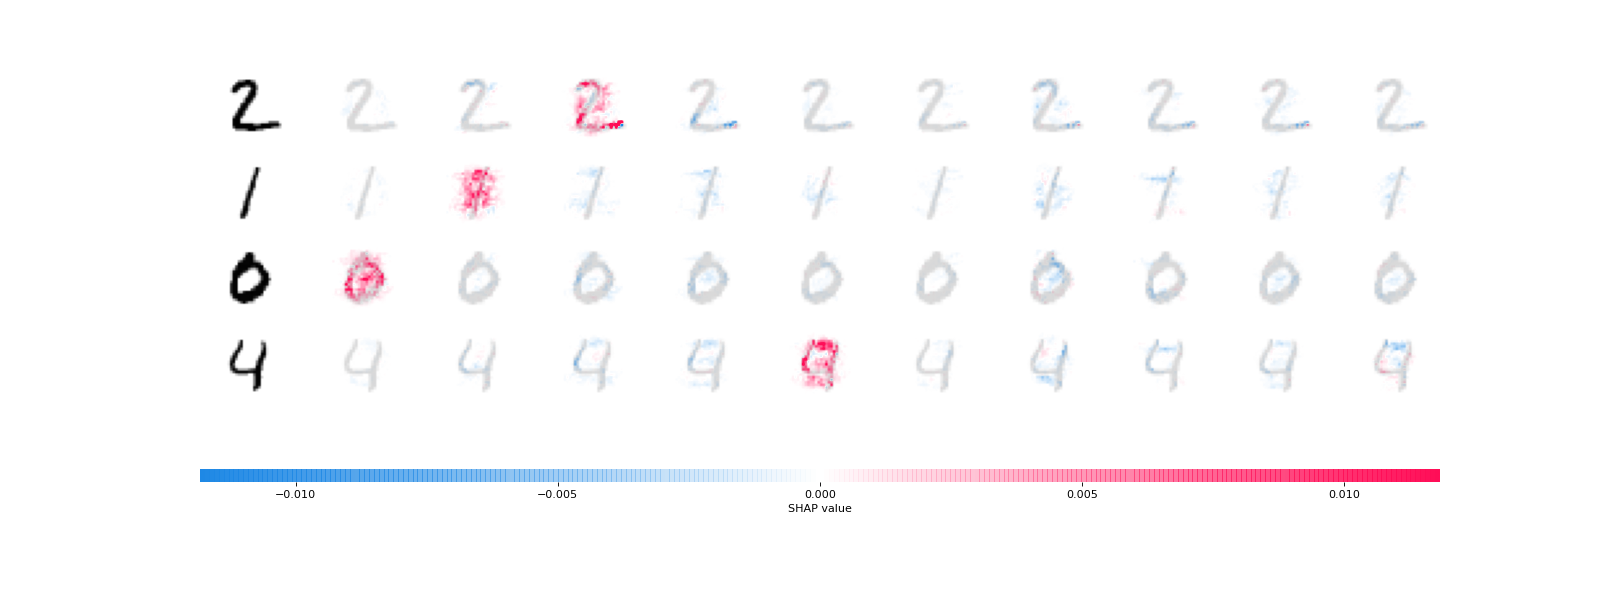

In [16]:
# this is a hack
shap.explainers.deep.deep_tf.op_handlers["AddV2"] = shap.explainers.deep.deep_tf.passthrough

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(x_test[1:5], check_additivity=False)

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])

**General remarks:**

Look at the last row and see how the top pixels in the four are red for the `4` class, while they are blue for the `9` class.

**Exploitation:**

We could exploit these weakness even further and aim for a single pixel attack, here you could find a famous [paper](https://arxiv.org/pdf/1710.08864.pdf) on the topic.